## Customer Retention Cohort Analysis

#### Business goal
Understand how long customers keep coming back after their first purchase and identify churn patterns over time.

###### Loading libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# loading dataset
df = pd.read_csv("online_retail.csv")

In [7]:
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
# understanding the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        541909 non-null  int64  
 1   InvoiceNo    541909 non-null  object 
 2   StockCode    541909 non-null  object 
 3   Description  540455 non-null  object 
 4   Quantity     541909 non-null  int64  
 5   InvoiceDate  541909 non-null  object 
 6   UnitPrice    541909 non-null  float64
 7   CustomerID   406829 non-null  float64
 8   Country      541909 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 37.2+ MB


###### Key Observations

* 541,909 transactions

* CustomerID has missing values

* InvoiceDate is stored as text

* Dataset contains multiple countries

* Suitable for time-based cohort analysis

###### Data cleaning

In [9]:
# Removing missing values from customer
df = df.dropna(subset=['CustomerID'])

In [10]:
# converting invoicedate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
# Removing invalid transactions
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

###### Creating the cohort month

In [12]:
# Identify each customer first purchase date
df['CohortMonth'] = (
    df.groupby('CustomerID')['InvoiceDate']
      .transform('min')
      .dt.to_period('M')
)

###### Meaning:
Each customer is assigned to a cohort based on the month of their first purchase.

In [13]:
# Extracting transaction month
df['TransactionMonth'] = df['InvoiceDate'].dt.to_period('M')

###### Meaning:
This captures when each transaction occurred, relative to the cohort start.

###### Creating cohort index (time since the first purchase)

In [14]:
# How many months after the first purchase did the transaction occur?
df['CohortIndex'] = (
    (df['TransactionMonth'].dt.year - df['CohortMonth'].dt.year) * 12
    + (df['TransactionMonth'].dt.month - df['CohortMonth'].dt.month)
    + 1
)

###### Interpretation:

1 - first purchase month

2 - one month later

Measures customer lifetime in months

###### Building the cohort table

In [15]:
# Active customers per cohort per month
cohort_data = (
    df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID']
      .nunique()
      .reset_index()
)

In [16]:
# Pivot into cohort matrix
cohort_pivot = cohort_data.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='CustomerID'
)

In [17]:
cohort_pivot

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### Meaning:
Counts how many unique customers are active in each cohort-month.

######  Retention rate

In [18]:
# cohort size (month1)
cohort_size = cohort_pivot.iloc[:, 0]

In [20]:
cohort_size.head()

CohortMonth
2010-12    885.0
2011-01    417.0
2011-02    380.0
2011-03    452.0
2011-04    300.0
Freq: M, Name: 1, dtype: float64

In [21]:
# Retention percentage
retention = cohort_pivot.divide(cohort_size, axis=0)

In [22]:
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN
2011-05,1.0,0.190141,0.172535,0.172535,0.207746,0.232394,0.264085,0.095070,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.173554,0.157025,0.264463,0.231405,0.334711,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.180851,0.207447,0.223404,0.271277,0.111702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.207101,0.248521,0.242604,0.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### nterpretation:
Shows the percentage of customers retained in each subsequent month.

###### Visualize Retention (heatmap)

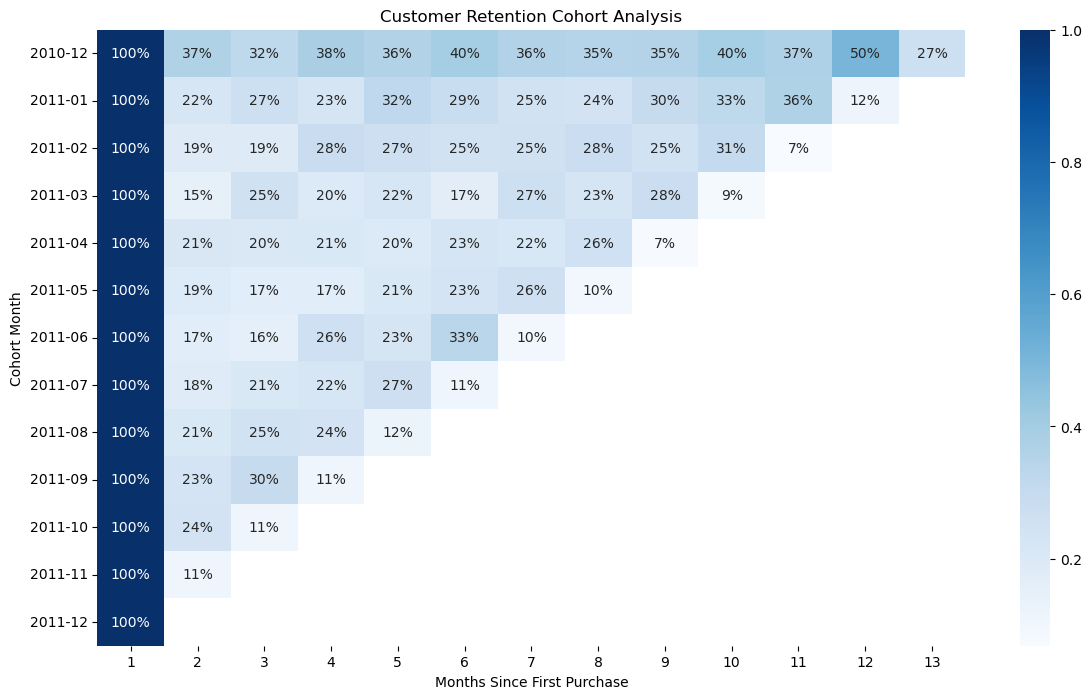

In [23]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    retention,
    annot=True,
    fmt='.0%',
    cmap='Blues'
)
plt.title('Customer Retention Cohort Analysis')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.show()

#### Interpretation
The cohort heatmap shows a sharp decline after the first purchase, indicating early churn. However, customers retained beyond Month 3 show strong loyalty, especially in early and holiday cohorts, highlighting opportunities for targeted retention strategies.

###### Country based cohort

In [25]:
df.groupby(['Country', 'CohortMonth']).size().to_frame()

0
Country        CohortMonth       
Australia      2010-12        191
               2011-01        911
               2011-03         50
               2011-06         30
Austria        2010-12         29
...                           ...
United Kingdom 2011-11      11445
               2011-12        852
Unspecified    2011-04         23
               2011-05         56
               2011-07        165

[191 rows x 1 columns]

In [26]:
# Revenue retention
df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [28]:
# saving dataset
df.to_csv("online_retail_cleaned.csv", index=False)